In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

%matplotlib inline

# Data Consolidation for Optimization Modeling

In [115]:
#Trip prediction data for 1/31/2019
path = "~/Documents/Berkeley MEng/Spring Semester/290/Project/datax_bikeshare/data/trips_final_20190301_20190331.csv"
data = pd.read_csv(path)
data.head()

,Unnamed: 0,start_date,station_id,station_cap,station_has_kiosk,trip_count_out,trip_count_in,trip_count_net,trip_count_net_prev7,trip_count_net_prev14,...,station_cluster_7,station_cluster_8,start_dow_Friday,start_dow_Monday,start_dow_Saturday,start_dow_Sunday,start_dow_Thursday,start_dow_Tuesday,start_dow_Wednesday,trip_count_predicted
0,93988,2019-03-01 00:00:00+00:00,3,35,True,66.0,61.0,-5.0,-11.0,-12.0,...,0,0,1,0,0,0,0,0,0,-4.0
1,93989,2019-03-01 00:00:00+00:00,4,35,True,13.0,17.0,4.0,13.0,16.0,...,0,0,1,0,0,0,0,0,0,4.0
2,93990,2019-03-01 00:00:00+00:00,5,35,True,50.0,53.0,3.0,8.0,3.0,...,0,0,1,0,0,0,0,0,0,10.0
3,93991,2019-03-01 00:00:00+00:00,6,23,True,48.0,37.0,-11.0,-9.0,-9.0,...,0,0,1,0,0,0,0,0,0,-9.0
4,93992,2019-03-01 00:00:00+00:00,8,23,True,22.0,7.0,-15.0,-21.0,-13.0,...,0,0,1,0,0,0,0,0,0,-13.0


In [116]:
#Net flow predicted for all stations on 03/31/2019
data_3_31_morning = data[(data['start_date'].str.match('2019-03-31')) & (data['start_period_morning']==1)]
bike_flow = data_3_31_morning['trip_count_predicted'].to_frame()
bike_flow.set_index(data_3_31_morning['station_id'], inplace=True)
bike_flow.columns = ['net']
bike_flow.head()

,net
station_id,
3,8.0
4,2.0
5,1.0
6,7.0
8,7.0


# Filter data to focus on most critically imbalanced stations

In [117]:
minflow, maxflow = -3, 3

I decided to focus on stations with a net bike flow outside of the range (-3,3) because those are the most unbalanced, and an LP solver will take far too long if it included every station. A plot below shows red dots, which will be the stations to focus on.

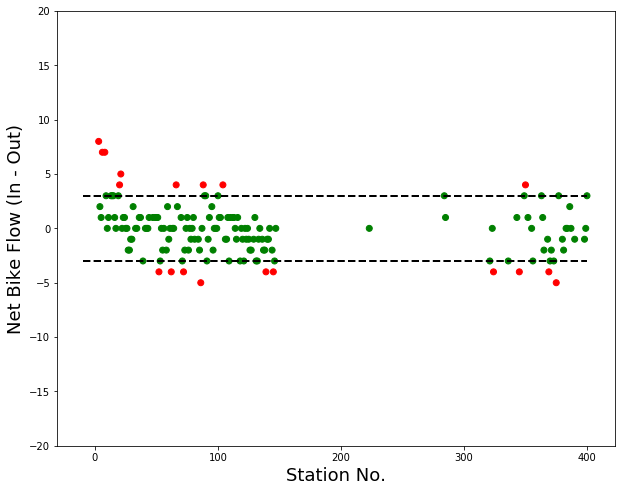

In [118]:
x = bike_flow.index
y = bike_flow['net'].values

plt.figure(figsize=(10,8))
plt.xlabel('Station No.', fontsize=18)
plt.ylabel('Net Bike Flow (In - Out)', fontsize=18)
plt.ylim(-20,20)
plt.plot([-10, 400], [maxflow, maxflow], color='k', linestyle='--', linewidth=2)
plt.plot([-10, 400], [minflow, minflow], color='k', linestyle='--', linewidth=2)
col = np.where(x<0,'k',np.where(np.logical_or(y>maxflow,y<minflow),'r','g'))
plt.scatter(x,y, color=col);

In [119]:
#Create source dataframe, with all stations that have large in-traffic
source_flow = bike_flow[bike_flow['net']>maxflow]
source_flow['net']

station_id
3      8.0
6      7.0
8      7.0
20     4.0
21     5.0
66     4.0
88     4.0
104    4.0
350    4.0
Name: net, dtype: float64

In [120]:
source_flow.shape[0]

9

In [121]:
#Create sink dataframe, with all stations that have large out-traffic
sink_flow = bike_flow[bike_flow['net']<minflow]
sink_flow['net']

station_id
52    -4.0
62    -4.0
72    -4.0
86    -5.0
139   -4.0
145   -4.0
324   -4.0
345   -4.0
369   -4.0
375   -5.0
Name: net, dtype: float64

In [122]:
sink_flow.shape[0]

10

# Calculate Distances Between Relevant Stations

In [123]:
#Get locations of all stations (for distance calculation)
path2 = "~/Documents/Berkeley MEng/Spring Semester/290/Project/datax_bikeshare/data/trip_summary_201901.csv"
locations = pd.read_csv(path2)
cols = ['start_station_id', 'start_station_latitude', 'start_station_longitude']
locations = locations[cols].drop_duplicates().set_index('start_station_id').sort_index()
locations.head()

,start_station_latitude,start_station_longitude
start_station_id,,
3,37.786375,-122.404904
4,37.785881,-122.408915
5,37.783899,-122.408445
6,37.804770,-122.403234
7,37.804562,-122.271738


In [124]:
#Function to calculate distance between two stations
def distance(station1id, station2id):
    a = locations.loc[station1id].values
    b = locations.loc[station2id].values
    return np.linalg.norm(a-b)

In [125]:
#Build a DataFrame of distances for all source-sink combinations
distances = pd.DataFrame(columns=['source','sink','distance'])
for i in source_flow.index:
    for j in sink_flow.index:
        distances = distances.append({'source': int(i), 'sink': int(j), 'distance': distance(i,j)}, ignore_index=True)
distances.head()

,source,sink,distance
0,3.0,52.0,0.038004
1,3.0,62.0,0.008720
2,3.0,72.0,0.033770
3,3.0,86.0,0.027784
4,3.0,139.0,0.036044


In [126]:
#Pivot data for more organized format
distances = distances.pivot(index='source',columns='sink',values='distance')
distances

sink,52.0,62.0,72.0,86.0,139.0,145.0,324.0,345.0,369.0,375.0
source,,,,,,,,,,
3.0,0.038004,0.008720,0.033770,0.027784,0.036044,0.047982,0.004105,0.020970,0.011787,0.043210
6.0,0.047313,0.027168,0.045806,0.042595,0.054447,0.065476,0.017301,0.038613,0.021989,0.052649
8.0,0.048825,0.023531,0.046229,0.041716,0.050731,0.062976,0.015359,0.033480,0.022077,0.054193
20.0,0.044983,0.015394,0.041188,0.035429,0.042283,0.055115,0.009943,0.024837,0.018038,0.050267
21.0,0.042805,0.013102,0.038862,0.033010,0.040169,0.052786,0.007833,0.023287,0.016003,0.048066
66.0,0.049115,0.013724,0.043374,0.035367,0.033701,0.048882,0.018458,0.013466,0.025412,0.053946
88.0,0.031004,0.009394,0.024042,0.015117,0.019014,0.030356,0.018547,0.013893,0.018006,0.035150
104.0,0.052048,0.018942,0.045136,0.036063,0.026471,0.042892,0.027658,0.007484,0.032845,0.056254
350.0,0.036544,0.006392,0.029879,0.021146,0.021310,0.034810,0.017090,0.008983,0.019272,0.040901


In [127]:
#Exported to csv: distances, source_flow, sink_flow

# AMPL Optimization

AMPL model looks like this:

```
set source; set sink;

var x{source, sink} >= 0;

param distance{source, sink};
param sourceflow{source};
param sinkflow{sink};

minimize total_cost: sum{i in source, j in sink} distance[i,j] * x[i,j];

subject to source_goal{i in source}:  sum{j in sink} -x[i,j] + sourceflow[i] <=  3;
subject to source_limit{i in source}: sum{j in sink} -x[i,j] + sourceflow[i] >= -3;
subject to sink_goal{j in sink}:      sum{i in source}  x[i,j] + sinkflow[j] >= -3;
subject to sink_limit{j in sink}:     sum{i in source}  x[i,j] + sinkflow[j] <=  3;
```

And the data file:

```
set source := so3 so6 so8 so20 so21 so66 so88 so104 so350;
set sink := si52 si62 si72 si86 si139 si145 si324 si345 si369 si375;

param distance: si52 si62 si72 si86 si139 si145 si324 si345 si369 si375 :=								
so3     0.038004	0.008720	0.033770	0.027784	0.036044	0.047982	0.004105	0.020970	0.011787	0.043210
so6     0.047313	0.027168	0.045806	0.042595	0.054447	0.065476	0.017301	0.038613	0.021989	0.052649
so8     0.048825	0.023531	0.046229	0.041716	0.050731	0.062976	0.015359	0.033480	0.022077	0.054193
so20    0.044983	0.015394	0.041188	0.035429	0.042283	0.055115	0.009943	0.024837	0.018038	0.050267
so21    0.042805	0.013102	0.038862	0.033010	0.040169	0.052786	0.007833	0.023287	0.016003	0.048066
so66    0.049115	0.013724	0.043374	0.035367	0.033701	0.048882	0.018458	0.013466	0.025412	0.053946
so88    0.031004	0.009394	0.024042	0.015117	0.019014	0.030356	0.018547	0.013893	0.018006	0.035150
so104   0.052048	0.018942	0.045136	0.036063	0.026471	0.042892	0.027658	0.007484	0.032845	0.056254
so350   0.036544	0.006392	0.029879	0.021146	0.021310	0.034810	0.017090	0.008983	0.019272	0.040901
;

param sourceflow:=
so3     8.0
so6     7.0
so8     7.0
so20    4.0
so21    5.0
so66    4.0
so88    4.0
so104   4.0
so350   4.0
;

param sinkflow:=
si52   -4.0
si62   -4.0
si72   -4.0
si86   -5.0
si139  -4.0
si145  -4.0
si324  -4.0
si345  -4.0
si369  -4.0
si375  -5.0
;
```

# Result

In [128]:
path3 = "~/Documents/Berkeley MEng/Spring Semester/290/Project/datax_bikeshare/model/Optimization/optimized_flow2.csv"
optimized_flow = pd.read_csv(path3)
optimized_flow = optimized_flow.pivot(index='source',columns='sink',values='added_flow')
optimized_flow

sink,52,62,72,86,139,145,324,345,369,375
source,,,,,,,,,,
3,0,5,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,1,2
8,0,0,0,0,0,0,4,0,0,0
20,0,0,0,0,0,0,1,0,0,0
21,0,0,0,0,0,0,2,0,0,0
66,0,0,0,0,0,0,0,1,0,0
88,0,0,1,2,0,1,0,0,0,0
104,0,0,0,0,0,0,0,1,0,0
350,0,0,0,0,1,0,0,0,0,0


In order to improve the balance of stations, operators can take a number of bikes from `source` stations, specified above, and transport them to the corresponding `sink` stations. This particular arrangement ensures all stations experience no net flow outside of the range of (-3,3) bikes per day.

In [129]:
#Change in flow expected by implementing this solution. Note: Negative numbers mean bike out-flow
net_flow_change = (optimized_flow).sum(axis=0).append(-optimized_flow.sum(axis=1)).rename('added_flow')
net_flow_change

52     1
62     5
72     1
86     2
139    1
145    1
324    7
345    2
369    1
375    2
3     -5
6     -4
8     -4
20    -1
21    -2
66    -1
88    -4
104   -1
350   -1
Name: added_flow, dtype: int64

In [130]:
#New bike flow after flow change
bike_flow = pd.concat([bike_flow, net_flow_change], axis=1).fillna(value=0)
bike_flow['new_net'] = bike_flow['net'] + bike_flow['added_flow']
bike_flow.head()

,net,added_flow,new_net
3,8.0,-5.0,3.0
4,2.0,0.0,2.0
5,1.0,0.0,1.0
6,7.0,-4.0,3.0
8,7.0,-4.0,3.0


In [131]:
#All stations with a change in net flow
bike_flow[bike_flow['added_flow']!=0]

,net,added_flow,new_net
3,8.0,-5.0,3.0
6,7.0,-4.0,3.0
8,7.0,-4.0,3.0
20,4.0,-1.0,3.0
21,5.0,-2.0,3.0
52,-4.0,1.0,-3.0
62,-4.0,5.0,1.0
66,4.0,-1.0,3.0
72,-4.0,1.0,-3.0
86,-5.0,2.0,-3.0


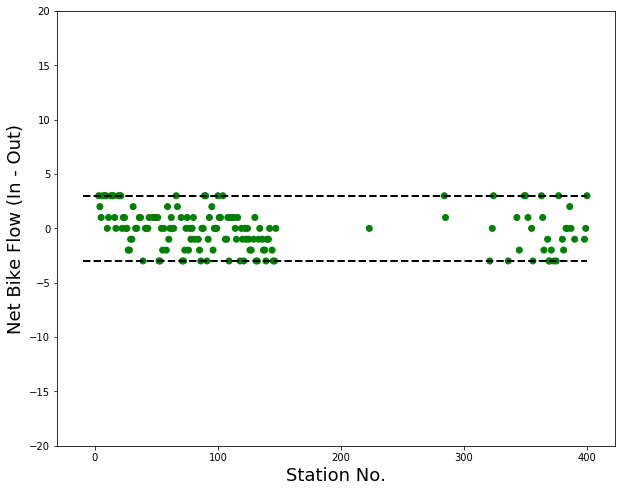

In [132]:
x = bike_flow.index
y = bike_flow['new_net'].values

plt.figure(figsize=(10,8))
plt.xlabel('Station No.', fontsize=18)
plt.ylabel('Net Bike Flow (In - Out)', fontsize=18)
plt.ylim(-20,20)
plt.plot([-10, 400], [maxflow, maxflow], color='k', linestyle='--', linewidth=2)
plt.plot([-10, 400], [minflow, minflow], color='k', linestyle='--', linewidth=2)
col = np.where(x<0,'k',np.where(np.logical_or(y>maxflow,y<minflow),'r','g'))
plt.scatter(x,y, color=col);

Through optimization, the flow of bikes is now much more manageable. All stations experience a net flow of anywhere between -3 and 3 bikes per day.